In [1]:
import itertools
import numpy as np
import math
#import matplotlib
import matplotlib.pyplot as plt
#import numba as nb
import threading as thd
#import logging as lg
from util_tools.operators import *
from util_tools.update_funcs import *
#problem constants
var_dict = {}
var_dict['nu']=1e-6
var_dict['mu']=1e-3
var_dict['rho']=1e+3
var_dict['st_coef']=0.06
#real timestep
var_dict['dt']=0.0001
var_dict['gradP']=-2.4

n_iter=0
global epstot
'''
node generation section
'''
#domain length

Lx1=var_dict['Lx1']=0.02
Lx2=var_dict['Lx2']=0.01

r_dpl=var_dict['r_dpl']=0.25*var_dict['Lx2']
#number of cells on each direction
Nx1=var_dict['Nx1']=120
Nx2=var_dict['Nx2']=60

cell_vol=var_dict['cell_vol']=(Lx1/Nx1)*(Lx2/Nx2)

#mesh spacing
h=var_dict['h']=Lx1/Nx1

#redistancing pseudo-time count
tau=0.0
#redistancing pseudo-time step
dtau= var_dict['dtau']= 0.5*h

#smoothing range
M=var_dict['M']=3.0
#uave
u1_ave=var_dict['u1_ave']=0.02

    
epstot=100.0
p_iter=0
#cell centroid coor
#the +2 stands for ghost cells on each direction
cell_cent_x=np.zeros([Nx1+2,Nx2+2])
cell_cent_y=np.zeros([Nx1+2,Nx2+2])

cell_cent_pn=np.zeros([Nx1+2,Nx2+2])
cell_cent_pnn=np.zeros([Nx1+2,Nx2+2])

cell_cent_phin=np.zeros([Nx1+2,Nx2+2])
cell_cent_phis=np.zeros([Nx1+2,Nx2+2])
cell_cent_phinn=np.zeros([Nx1+2,Nx2+2])

cell_cent_phi_dn=np.zeros([Nx1+2,Nx2+2])
cell_cent_phi_ds=np.zeros([Nx1+2,Nx2+2])
cell_cent_phi_dnn=np.zeros([Nx1+2,Nx2+2])

cell_cent_rho=np.zeros([Nx1+2,Nx2+2])
cell_cent_mu=np.zeros([Nx1+2,Nx2+2])
#cell corner coor
cell_cor_x=np.zeros([Nx1+3,Nx2+3])
cell_cor_y=np.zeros([Nx1+3,Nx2+3])

#surf area of the cell 
cell_S_x=np.zeros([Nx1+2,Nx2+2])
cell_S_y=np.zeros([Nx1+2,Nx2+2])

cell_S_x_coor_x=np.zeros([Nx1+2,Nx2+2])
cell_S_x_coor_y=np.zeros([Nx1+2,Nx2+2])
cell_S_y_coor_x=np.zeros([Nx1+2,Nx2+2])
cell_S_y_coor_y=np.zeros([Nx1+2,Nx2+2])

#normal vector of cell surfaces
cell_S_x_nx=np.zeros([Nx1+2,Nx2+2])
cell_S_x_ny=np.zeros([Nx1+2,Nx2+2])
cell_S_y_nx=np.zeros([Nx1+2,Nx2+2])
cell_S_y_ny=np.zeros([Nx1+2,Nx2+2])
#surface velocities
cell_S_x_un=np.zeros([Nx1+2,Nx2+2])
cell_S_x_us=np.zeros([Nx1+2,Nx2+2])
cell_S_x_unn=np.zeros([Nx1+2,Nx2+2])

cell_S_y_vn=np.zeros([Nx1+2,Nx2+2])
cell_S_y_vs=np.zeros([Nx1+2,Nx2+2])
cell_S_y_vnn=np.zeros([Nx1+2,Nx2+2])
#reference velocity profile
ref_S_u=np.zeros([Nx2+2])
L_sq=np.array([1.0,1.0])

#corner coor initialization
cell_cor_x, cell_cor_y = np.meshgrid((Lx1/Nx1)*np.linspace(-1, Nx1+1, Nx1+3), (Lx1/Nx1)*np.linspace(-1, Nx2+1, Nx2+3),indexing='ij')
        
#cell cent coor storage


cell_cent_x[0:Nx1+2,0:Nx2+2]=0.25*(cell_cor_x[0:Nx1+2,0:Nx2+2]+cell_cor_x[0+1:Nx1+2+1,0:Nx2+2]+cell_cor_x[0:Nx1+2,0+1:Nx2+2+1]+cell_cor_x[0+1:Nx1+2+1,0+1:Nx2+2+1])

cell_cent_y[0:Nx1+2,0:Nx2+2]=0.25*(cell_cor_y[0:Nx1+2,0:Nx2+2] + cell_cor_y[0+1:Nx1+2+1,0:Nx2+2] + cell_cor_y[0:Nx1+2,0+1:Nx2+2+1]+cell_cor_y[0+1:Nx1+2+1,0+1:Nx2+2+1])
#lvlset init
cell_cent_phin[0:Nx1+2,0:Nx2+2]=lvlset_init(cell_cent_x[0:Nx1+2,0:Nx2+2], cell_cent_y[0:Nx1+2,0:Nx2+2],var_dict)




cell_S_x_coor_x[0:Nx1+2,0:Nx2+2]=(cell_cor_x[0:Nx1+2,0:Nx2+2]+cell_cor_x[0:Nx1+2,0+1:Nx2+2+1])/2
cell_S_x_coor_y[0:Nx1+2,0:Nx2+2]=(cell_cor_y[0:Nx1+2,0:Nx2+2]+cell_cor_y[0:Nx1+2,0+1:Nx2+2+1])/2
cell_S_y_coor_x[0:Nx1+2,0:Nx2+2]=(cell_cor_x[0:Nx1+2,0:Nx2+2]+cell_cor_x[0+1:Nx1+2+1,0:Nx2+2])/2
cell_S_y_coor_y[0:Nx1+2,0:Nx2+2]=(cell_cor_y[0:Nx1+2,0:Nx2+2]+cell_cor_y[0+1:Nx1+2+1,0:Nx2+2])/2
cell_cent_rho[0:Nx1+2,0:Nx2+2]=rho_distr(cell_cent_phin[0:Nx1+2,0:Nx2+2],var_dict)
cell_cent_mu[0:Nx1+2,0:Nx2+2]=mu_distr(cell_cent_phin[0:Nx1+2,0:Nx2+2],var_dict)



cell_S_x[0:Nx1+2,0:Nx2+2]=abs(cell_cor_y[0:Nx1+2,0:Nx2+2]-cell_cor_y[0:Nx1+2,0+1:Nx2+2+1])
cell_S_y[0:Nx1+2,0:Nx2+2]=abs(cell_cor_x[0:Nx1+2,0:Nx2+2]-cell_cor_x[0+1:Nx1+2+1,0:Nx2+2])

cell_S_x_nx[0:Nx1+2,0:Nx2+2]=(cell_cor_y[0:Nx1+2,0+1:Nx2+2+1]-cell_cor_y[0:Nx1+2,0:Nx2+2])/cell_S_x[0:Nx1+2,0:Nx2+2]
cell_S_x_ny[0:Nx1+2,0:Nx2+2]=(cell_cor_x[0:Nx1+2,0+1:Nx2+2+1]-cell_cor_x[0:Nx1+2,0:Nx2+2])/cell_S_x[0:Nx1+2,0:Nx2+2]
cell_S_y_nx[0:Nx1+2,0:Nx2+2]=(cell_cor_y[0+1:Nx1+2+1,0:Nx2+2]-cell_cor_y[0:Nx1+2,0:Nx2+2])/cell_S_y[0:Nx1+2,0:Nx2+2]
cell_S_y_ny[0:Nx1+2,0:Nx2+2]=(cell_cor_x[0+1:Nx1+2+1,0:Nx2+2]-cell_cor_x[0:Nx1+2,0:Nx2+2])/cell_S_y[0:Nx1+2,0:Nx2+2]


#initial conditions
cell_S_x_un[0:Nx1+2,0:Nx2+2]=ref_vel_prof(cell_cent_y[0:Nx1+2,0:Nx2+2])





In [2]:
for i in range(500):
    cell_cent_phis=phis_BC_looper(phis_looper(cell_cent_phis,cell_cent_phin,cell_S_x_un,cell_S_y_vn,var_dict),var_dict)
    cell_cent_phinn=phinn_BC_looper(phinn_looper(cell_cent_phin,cell_cent_phis,cell_cent_phi_ds,cell_cent_phin,cell_S_x_un,cell_S_x_us,cell_S_y_vn,var_dict),var_dict)
    cell_cent_phi_dnn=phi_dnn_looper(cell_cent_phi_dn, cell_cent_phinn, cell_cent_phi_dnn,cell_cent_phi_ds,cell_cent_phis,var_dict)
    cell_cent_rho=rho_distr(cell_cent_phin,var_dict)
    cell_cent_mu=mu_distr(cell_cent_phin,var_dict)
    cell_S_x_us=us_looper(cell_S_x_un, cell_cent_mu, cell_cent_rho, cell_S_x_us,var_dict)
    cell_S_x_us=us_BC_looper(cell_S_x_us,var_dict)
    cell_cent_pn=p_looper( cell_S_x_us, cell_S_y_vs,cell_S_x_unn,cell_S_y_vnn, cell_cent_pn, cell_cent_pnn,var_dict)
    cell_cent_pnn=p_BC_looper(cell_cent_pn,var_dict)
    cell_S_x_unn=unn_looper(cell_S_x_us, cell_cent_pnn, cell_S_x_unn, cell_cent_rho,var_dict)
    cell_S_x_unn=unn_BC_looper(cell_S_x_unn,var_dict)
    cell_S_x_un=cell_S_x_unn
    cell_cent_pnn=cell_cent_pn
    cell_cent_phin=cell_cent_phinn

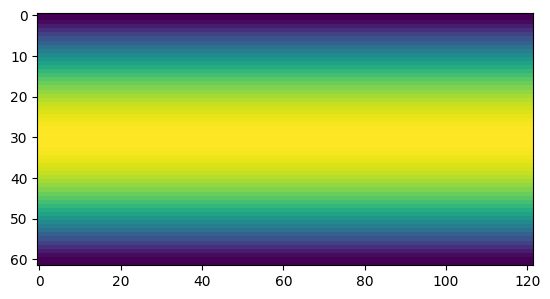

In [3]:
plt.imshow(cell_S_x_un.T)

In [ ]:
cell_cent_phis=phis_BC_looper(phis_looper(cell_cent_phis,cell_cent_phin,cell_S_x_un,cell_S_y_vn,var_dict),var_dict)
cell_cent_phinn=phinn_BC_looper(phinn_looper(cell_cent_phin,cell_cent_phis,cell_cent_phi_ds,cell_cent_phin,cell_S_x_un,cell_S_x_us,cell_S_y_vn,var_dict),var_dict)
cell_cent_phi_dnn=phi_dnn_looper(cell_cent_phi_dn, cell_cent_phinn, cell_cent_phi_dnn,cell_cent_phi_ds,cell_cent_phis,var_dict)
cell_cent_rho=rho_distr(cell_cent_phin,var_dict)
cell_cent_mu=mu_distr(cell_cent_phin,var_dict)
cell_S_x_us=us_looper(cell_S_x_un, cell_cent_mu, cell_cent_rho, cell_S_x_us,var_dict)
cell_S_x_us=us_BC_looper(cell_S_x_us,var_dict)
cell_cent_pn=p_looper( cell_S_x_us, cell_S_y_vs,cell_S_x_unn,cell_S_y_vnn, cell_cent_pn, cell_cent_pnn,var_dict)
cell_cent_pnn=p_BC_looper(cell_cent_pn,var_dict)
cell_S_x_unn=unn_looper(cell_S_x_us, cell_cent_pnn, cell_S_x_unn, cell_cent_rho,var_dict)
cell_S_x_unn=unn_BC_looper(cell_S_x_unn,var_dict)
cell_S_x_un=cell_S_x_unn
cell_cent_pnn=cell_cent_pn
cell_cent_phin=cell_cent_phinn
plt.imshow(cell_cent_phi_dnn.T)
print(cell_cent_phi_dnn)

In [ ]:
a=np.array([0,1,2,3,4])

In [ ]:
len(a)

In [ ]:
a[1:5]

In [ ]:
for i in range(1,5):
    print(a[i])